In [1]:
%matplotlib notebook

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy import stats
import statsmodels.api as sm

# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
import pandas as pd

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig1_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# Hyperscope data (larva) comes with 30 Hz image aquisition frequency
aq_rate = 30

# dose response

In [4]:
filename = 'Fig1IJ_JK73A'
# read the numpy array
data = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 1H and 1I 
which shows response of control animals wich UAS-Chrimson in JK73A
at 8uW/mm2, 47uW/mm2 and 72uW/mm2.

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 3. These are: 8uW/mm2, 47uW/mm2 and 72uW/mm2 

5th dimension is 1.


<IPython.core.display.Javascript object>


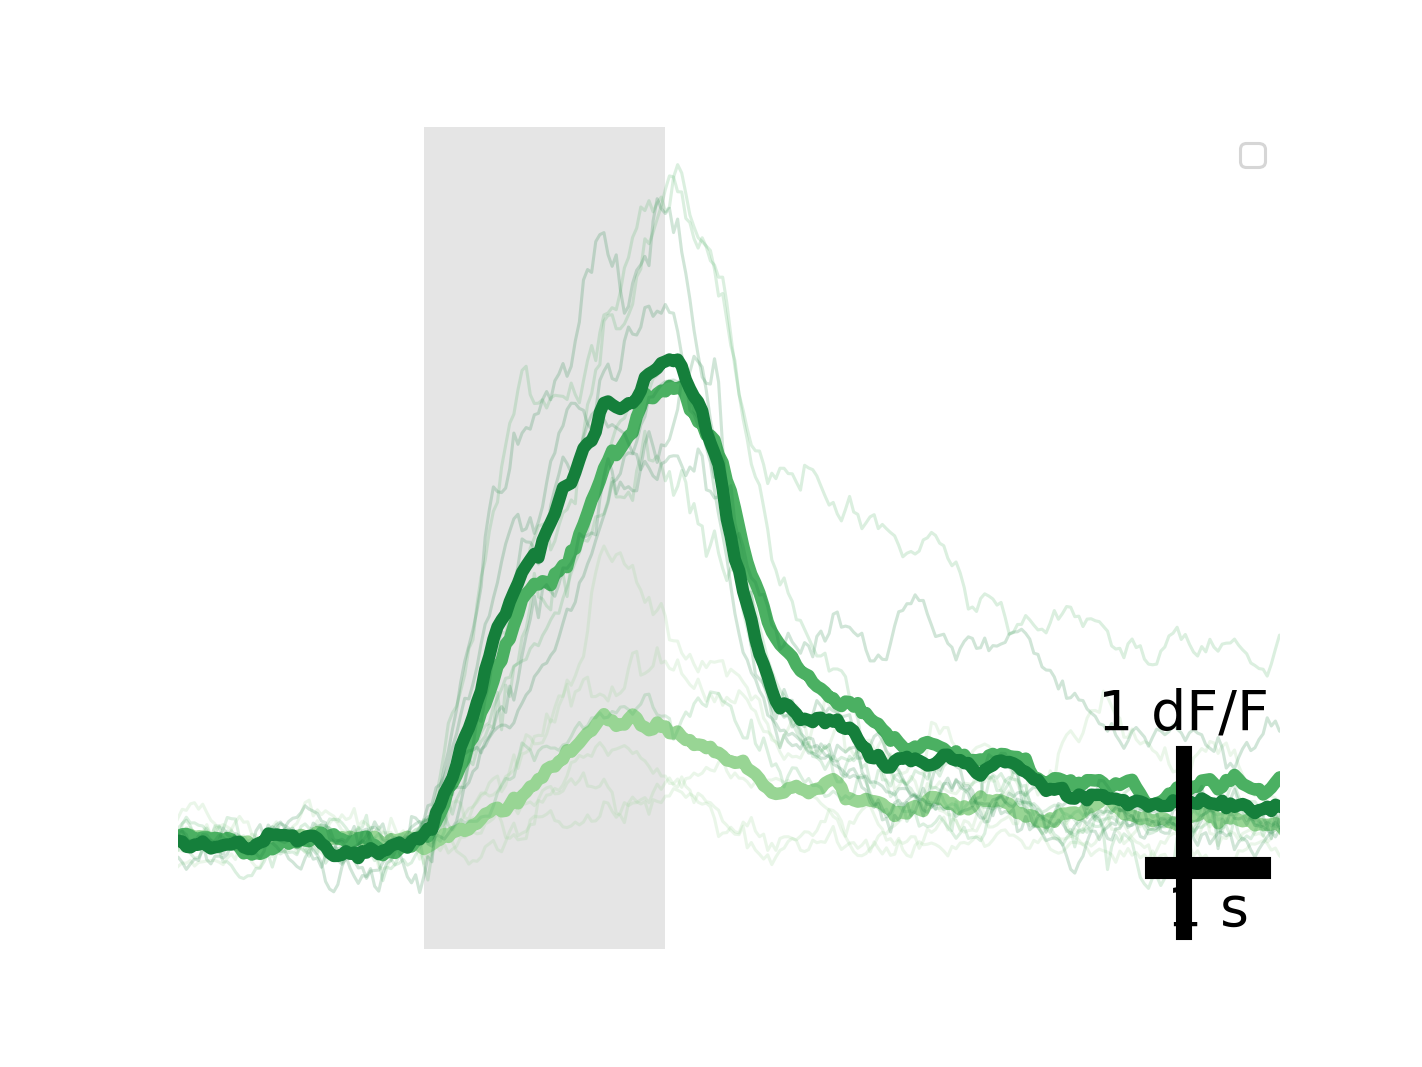

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [5]:
# Define colors used for this plot
start = 0.4
stop = 0.8
number_of_lines= data.shape[3]
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [matplotlib.cm.Greens(x) for x in cm_subsection ]
colors = np.array(colors)

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Here we have only one group
group = 0

for stim_intensity in range(3):

    ax.plot(data[:,0,0,stim_intensity,group], median_per_animal[:,:,stim_intensity,group], lw=1, zorder=1, 
            color=colors[stim_intensity], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity,group], np.mean(median_per_animal[:,:,stim_intensity,group], axis=1), 
            lw=4, zorder=1, color=colors[stim_intensity])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

savename = 'Fig1_I.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [6]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(stop_stim-aq_rate*0.5)) # take half second before the end of the stimulus...
during_end_index = int(round(stop_stim+aq_rate*0.5)) # ...until half second after the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


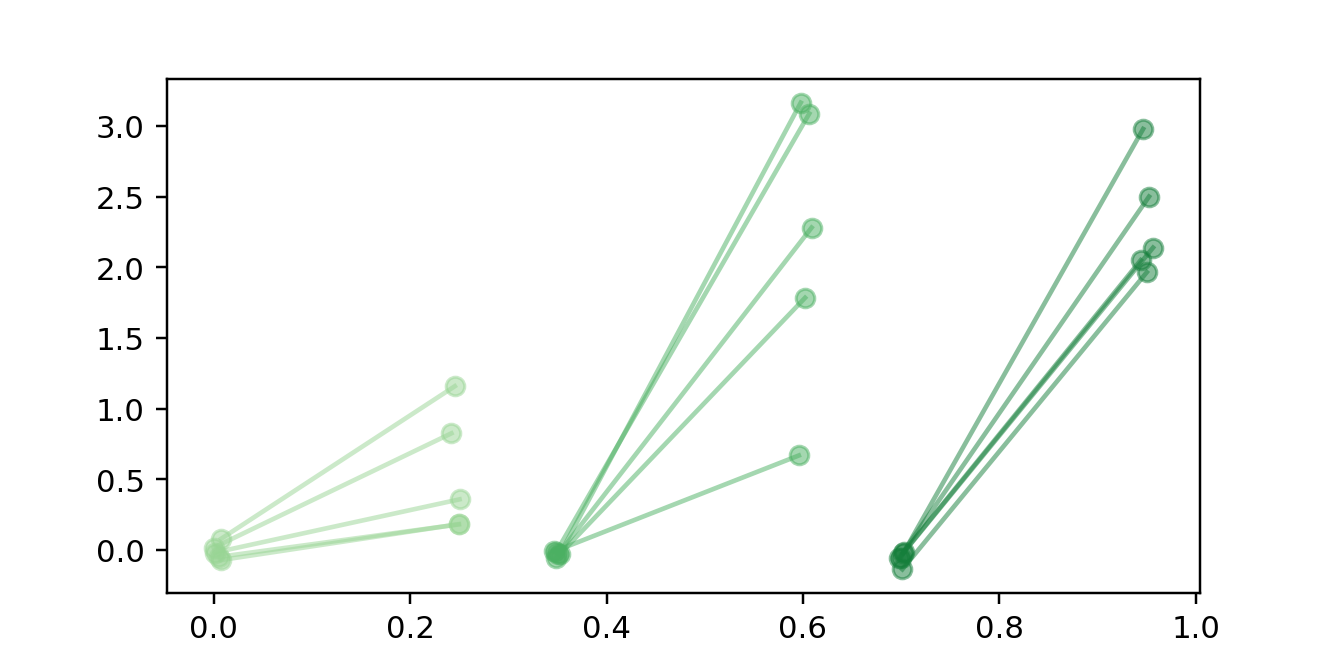

In [7]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=0, 
                           color=colors[0], start_x_position=0)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=1, 
                           color=colors[1], start_x_position=0.35)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=2, 
                           color=colors[2], start_x_position=0.7)
savename = 'Fig1_J.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [8]:
p_values=[]

# median_before_stim.shape
# (5, 3, 1) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim[:,0,0], median_before_stim[:,0,0], p_values) # 8 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,1,0], median_before_stim[:,1,0], p_values) # 47 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,2,0], median_before_stim[:,2,0], p_values) # 72 uW/mm2

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.2530258065606349
T-Test
TtestResult(statistic=3.2622218092795827, pvalue=0.031015735910028545, df=4)


lilliefors: 0.7510777771300227
T-Test
TtestResult(statistic=4.82793900156274, pvalue=0.008473960234887005, df=4)


lilliefors: 0.13087697202976217
T-Test
TtestResult(statistic=12.898492717094808, pvalue=0.00020834838949132482, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.00020834838949132482, current alpha: 0.016666666666666666
significantly different with:
current p: 0.008473960234887005, current alpha: 0.025
significantly different with:
current p: 0.031015735910028545, current alpha: 0.05


In [9]:
data = [[median_during_stim[:,0,0], median_before_stim[:,0,0]],
        [median_during_stim[:,1,0], median_before_stim[:,1,0]],
        [median_during_stim[:,2,0], median_before_stim[:,2,0]]
       ]

label_list_stat_export = [['During, 8uW/mm2', 'Before, 8uW/mm2'],
                          ['During, 47uW/mm2', 'Before, 47uW/mm2'],
                          ['During, 72uW/mm2', 'Before, 72uW/mm2']]
savename = 'Fig_1J'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

              Group  n      mean    median       STD       SEM  \
0   During, 8uW/mm2  5  0.542101  0.359107  0.388306  0.173656   
1   Before, 8uW/mm2  5 -0.007883 -0.017578  0.052682  0.023560   
2  During, 47uW/mm2  5  2.198508  2.282248  0.921452  0.412086   
3  Before, 47uW/mm2  5 -0.027632 -0.027704  0.017243  0.007711   
4  During, 72uW/mm2  5  2.327982  2.140164  0.373532  0.167049   
5  Before, 72uW/mm2  5 -0.056354 -0.054776  0.043490  0.019449   

                                95% CI on the mean  DOF statistical test  \
0      (0.0030459516833379885, 1.0811564014099737)  4.0       T-test rel   
1      (-0.08101750704991331, 0.06525218407423447)  NaN              NaN   
2         (0.9193272363473783, 3.4776878129459172)  4.0       T-test rel   
3  (-0.051568331457615094, -0.0036950911413381367)  NaN              NaN   
4           (1.80943647848549, 2.8465272679794884)  4.0       T-test rel   
5     (-0.11672799136759096, 0.004020472788491158)  NaN              NaN   

   t